In [1]:
# Official modules
import argparse
import os
import random
from time import strftime
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
# Self-defined modules
from efficientnet_pytorch import EfficientNet
from utils.logger import Logger
from utils.weighted_sampling import weighted_sampler_generator
from utils.dataset import DiamondDataset, DiamondDataset_zeropad

try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

In [2]:
# ArgumentParser
parser = argparse.ArgumentParser(description='PyTorch Diamond Training')
parser.add_argument('--data', metavar='/home/lingjia/Documents/diamond_data/inclusion_classification',  help='path to dataset')
parser.add_argument('--epochs', default=2, type=int, metavar='N',  help='number of total epochs to run')
parser.add_argument('--start_epoch', default=0, type=int, metavar='N',  help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch_size', default=256, type=int, metavar='N', 
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--image_size', default=224, type=int, help='image size')
parser.add_argument('--lr', '--learning_rate', default=0.1, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight_decay', default=1e-4, type=float, metavar='W', help='weight decay (default: 1e-4)', dest='weight_decay')
parser.add_argument('-p', '--print_freq', default=10, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--save_freq', default=10, type=int, help='checkpoint save frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true', help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
parser.add_argument('--gpu', default='0,1', type=str, help='GPU id to use.')
parser.add_argument('--advprop', default=False, action='store_true', help='use advprop or not')
parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet18',  help='model architecture (default: resnet18)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',  help='number of data loading workers (default: 4)')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--world_size', default=-1, type=int, help='number of nodes for distributed training')
parser.add_argument('--rank', default=-1, type=int, help='node rank for distributed training')
parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456', type=str, help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl', type=str,
                    help='distributed backend')
parser.add_argument('--seed', default=None, type=int, help='seed for initializing training. ')
parser.add_argument('--save_path', default=None, type=str, help='path for result. ')
parser.add_argument('--num_cls', default=None, type=int, help='number of classes ')
parser.add_argument('--img_cls', default=None, type=str)
parser.add_argument('--min_lr', default=None, type=float)
parser.add_argument('--max_lr', default=None, type=float)
parser.add_argument('--zeropad', default=0, type=int, help='whether to resize or zero-padding')

best_acc1 = 0
# args = parser.parse_args()
args,_ = parser.parse_known_args()

In [3]:
# Argument INPUT
# args.gpu='1'
# args.data='/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11'
# # args.epochs=3
# args.batch_size=64
# args.image_size=224
# # args.lr=1e-1
# # args.print_freq=10
# # args.save_freq=40
# args.arch='resnet101'
# args.save_path="/media/hdd/lingjia/hdd_diamond/cls/temp/2099-12-12-12-12-12"
# args.zeropad=0
# args.num_cls=4
# args.img_cls="Cloud-Crystal-Feather-Twinning_wisp"


# Argument INPUT - 1vsall version
args.save_path = '/media/hdd/lingjia/hdd_diamond/cls/temp/2099-12-12-12-12-12'
args.gpu='3'
# args.data='/media/hdd/lingjia/hdd_diamond/cls/data/cls5/exp1'
args.data = '/media/hdd/Bella/diamond_preprocessed/upscaled_diamond'
args.epochs=2
args.batch_size=64
args.image_size=224
# args.lr=0
args.arch='efficientnet-b0' # 'efficientnet-b0'
# args.num_cls=5
# args.img_cls='Cloud-Crystal-Feather-Needle-Twinning_wisp'
args.num_cls = 4
args.img_cls = 'Cloud-Crystal-Feather-Twinning_wisp'

# args.img_cls = 'Cloud-other'
# args.img_cls = 'Needle-other'
# args.img_cls = 'Crystal-other'


# def Main
ngpus_per_node = len(args.gpu.split(','))
args.distributed = ngpus_per_node>1   # args.world_size > 1 or args.multiprocessing_distributed
args.img_cls = args.img_cls.split('-') if args.img_cls else None

# print args
# for k,v in args._get_kwargs():
#     print('=> {}: {}'.format(k,v))

args.rank = 0
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

gpu = args.gpu
ngpus_per_node = ngpus_per_node
args = args

In [4]:
class Net(nn.Module):
    def __init__(self , model, num_cls):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        # self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.resnet_layer = nn.Sequential(*list(model.children()))
        # numFit = model.fc.out_features
        
        # self.transion_layer = nn.ConvTranspose2d(2048, 2048, kernel_size=14, stride=3)
        # self.pool_layer = nn.MaxPool2d(32)  
        self.Linear_layer = nn.Linear(1000, num_cls)
        
    def forward(self, x):
        x = self.resnet_layer(x)
        print(x.shape)
 
        # x = self.transion_layer(x)
 
        # x = self.pool_layer(x)
 
        # x = x.view(x.size(0), -1) 
 
        x = self.Linear_layer(x)
        
        return x


In [5]:
# def Main_worker
args.world_size = ngpus_per_node
# os.makedirs(args.save_path,exist_ok=True)
global best_acc1

if args.rank == 0:
    logger = Logger(os.path.join(args.save_path, f"{strftime('%H-%M-%S')}_tb"))
    print("=> Use GPU: {} for training".format(args.gpu))

# if args.distributed:
#     init_DDP(args)

# Create model
if 'efficientnet' in args.arch:
    if args.pretrained:
        model = EfficientNet.from_pretrained(args.arch, advprop=args.advprop)
        if args.rank == 0:
            print("=> using pre-trained model '{}'".format(args.arch))
    else:
        if args.rank == 0:
            print("=> creating model '{}'".format(args.arch))
        model = EfficientNet.from_name(args.arch,num_classes=args.num_cls)
else:
    if args.pretrained:
        print("=> using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()
        # print(model)
        numFit = model.fc.in_features
        outFit = model.fc.out_features
        print(numFit)
        model.fc = nn.Linear(numFit, args.num_cls)
        # print(model.fc)
        
        # resnet = models.resnet50(pretrained=True) # 原模型，并加载预训练参数
        # model = Net(model,args.num_cls) # 继承原模型的部分结构及相应参数，构建新架构
        
        # model.fc = nn.Sequential(nn.Linear(numFit, outFit),nn.Linear(outFit, args.num_cls))

        


model.cuda()
if args.distributed:
    # DistributedDataParallel will divide and allocate batch_size to all
    # available GPUs if device_ids are not set
    # model.cuda()
    model = torch.nn.parallel.DistributedDataParallel(model)


# define loss function (criterion) and optimizer
if args.num_cls == 1:
    criterion = nn.BCEWithLogitsLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum,
                            weight_decay=args.weight_decay)

# scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=args.min_lr, max_lr=args.max_lr)
# print(f'=> CyclicLR with min lr={args.min_lr} max lr={args.max_lr}')
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, threshold=0.0001, 
                                            min_lr=1e-7, eps=1e-08, verbose=True)
# scheduler = None

# optionally resume from a checkpoint
if args.resume:
    assert os.path.isfile(args.resume), f"=> No checkpoint found at {args.resume}"
    print(f"=> loading checkpoint {args.resume}")
    checkpoint = torch.load(args.resume)
    args.start_epoch = checkpoint['epoch']
    best_acc1 = checkpoint['best_acc1'].to('cuda')
    # if args.gpu is not None:
        # best_acc1 may be from a checkpoint from a different GPU
        # best_acc1 = best_acc1.to('cuda')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print(f"=> loaded epoch {checkpoint['epoch']})")


cudnn.benchmark = True

# Load dataset
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')
# if args.advprop:
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize(mean=[0.3364, 0.3477, 0.3473], std=[0.1371, 0.1415, 0.1424])

if 'efficientnet' in args.arch:
    image_size = EfficientNet.get_image_size(args.arch)
else:
    image_size = args.image_size
if args.rank == 0:
    print('=> Using image size', image_size)

transforms_list = [transforms.RandomRotation(30),
                    transforms.RandomVerticalFlip(0.5),
                    transforms.RandomHorizontalFlip(0.5)
                    ]

if args.zeropad == 1:
    train_dataset = DiamondDataset_zeropad(
        traindir,
        img_cls=args.img_cls,
        transform=transforms.Compose([
            # transforms.RandomChoice(transforms_list),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,])
    )
elif args.zeropad == 0:
    train_dataset = DiamondDataset(
        traindir,
        img_cls=args.img_cls,
        transform=transforms.Compose([
            # transforms.RandomResizedCrop((image_size,image_size)),
            transforms.Resize((image_size,image_size),interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomChoice(transforms_list),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,])   
    )
print(f"=> Classes: {train_dataset.classes}")
print(f"=> Unique labels: {torch.unique(torch.tensor(train_dataset.targets), return_counts=True)}")

if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None
    # train_sampler = weighted_sampler_generator(train_dataset)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
    num_workers=args.workers, sampler=train_sampler)

if args.zeropad == 1:
    val_dataset = DiamondDataset_zeropad(
        valdir, 
        img_cls=args.img_cls, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,])
    )
elif args.zeropad == 0:
    val_dataset = DiamondDataset(
        valdir, 
        img_cls=args.img_cls, 
        transform=transforms.Compose([
            # transforms.RandomResizedCrop((image_size,image_size)),
            transforms.Resize((image_size,image_size), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalize,])
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=False) #pin_memory=True
print(model)


=> Use GPU: 3 for training
=> creating model 'efficientnet-b0'
=> Using image size 224
=> Classes: ['Cloud', 'Crystal', 'Feather', 'Twinning_wisp']
=> Unique labels: (tensor([0, 1, 2, 3]), tensor([10723, 14580,  1102,  1477]))
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2d

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.40E-01


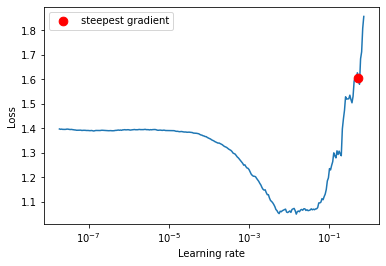

In [10]:
# LR Find
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum,
                            weight_decay=args.weight_decay)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-8, end_lr=1, num_iter=300, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-04


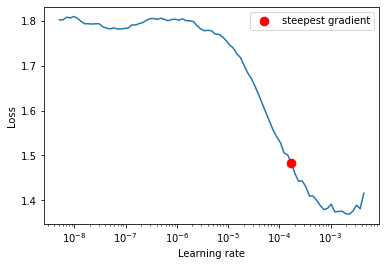

In [5]:
# LR Find
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum,
                            weight_decay=args.weight_decay)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-9, end_lr=1e-2, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()


# resnet 5

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.10E-04


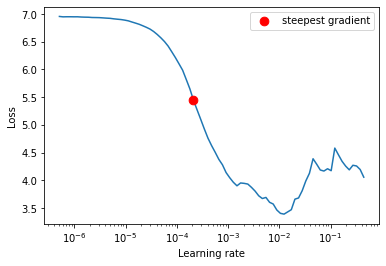

In [15]:
# LR Find
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum,
                            weight_decay=args.weight_decay)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

# original resnet 1000

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-03


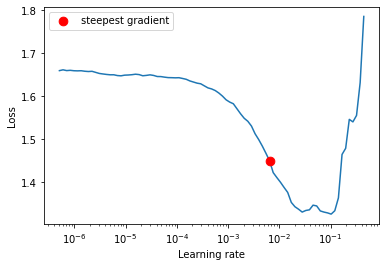

In [5]:
# LR Find
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum,
                            weight_decay=args.weight_decay)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()


# efficientnet

In [ ]:
# Result

"""

2022-11-03
Setting: Resize + Plain dataset + Data Aug (Hflip, Vflip, rotation(30)) + Usual Normalize
- img_cls='Cloud-Crystal-Feather-Twinning_wisp'
resnet101
bestlr=




Before 2022-11-03 
Setting: RandomCropResize + Plain dataset + Horizontal Flip
- img_cls='Cloud-Crystal-Feather-Needle-Twinning_wisp'
resnet18 bestlr=3e-3 range=[1e-5, 5e-5] bs=256
resnet101 bestlr=5e-3 range=[1e-5, 1e-2] bs=64

- img_cls='Cloud-other'
resnet101 bs=64 bestlr=5e-3 range=[1e-5, 1e-2]

- img_cls='Crystal-other'
resnet101 bs=64 bestlr= range=[1e-5,1e-2]

- img_cls='Needle-other'
resnet101 bs=64 bestlr=6e-5 range=[6e-5, 0.1]




"""
